# Script to plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


fe 7
ee 7
le 7
fa 7
ea 7
la 7
Average Total Effect 0.300130584017357
Best average indirect effect on last subject 0.049550250844081996
Best average indirect effect on last token 0.0652997202435342
Average best-fixed score 0.13593939
Average best-fixed on last subject token score 0.10918812
Average best-fixed on last word score 0.1267605
Argmax at last subject token 36
Max at last subject token 0.10918812
Argmax at last prompt token 36
Max at last prompt token 0.12493759


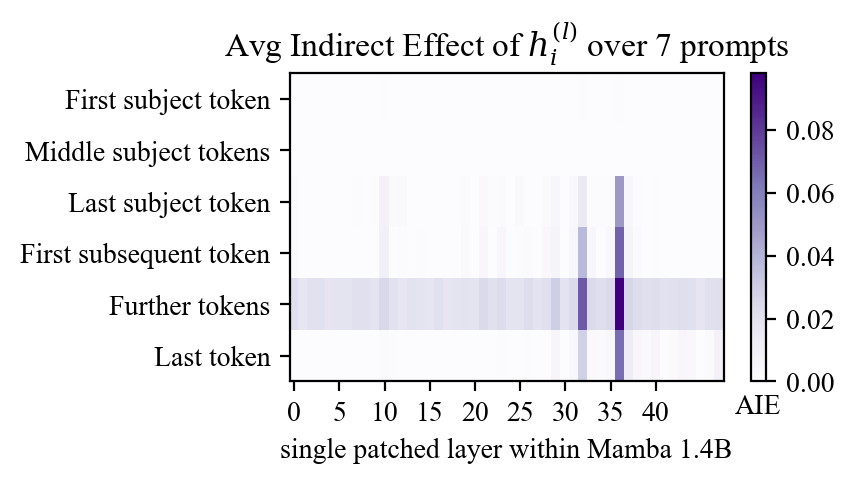

fe 7
ee 7
le 7
fa 7
ea 7
la 7
Average Total Effect 0.300130584017357
Best average indirect effect on last subject 0.013479427174648402
Best average indirect effect on last token 0.06624772466810619
Average best-fixed score 0.1340891
Average best-fixed on last subject token score 0.07482403
Average best-fixed on last word score 0.12729304
Argmax at last subject token 36
Max at last subject token 0.07311729
Argmax at last prompt token 36
Max at last prompt token 0.12588559


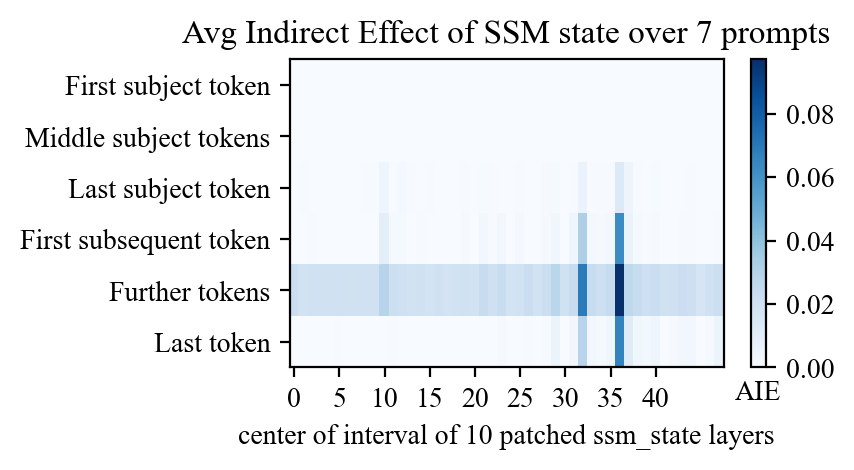

fe 6
ee 6
le 6
fa 6
ea 6
la 6
Average Total Effect 0.31038499639786704
Best average indirect effect on last subject 0.03815061615265829
Best average indirect effect on last token 0.002641774876489464
Average best-fixed score 0.1073728
Average best-fixed on last subject token score 0.10461953
Average best-fixed on last word score 0.07113936
Argmax at last subject token 36
Max at last subject token 0.10461953
Argmax at last prompt token 47
Max at last prompt token 0.06911069


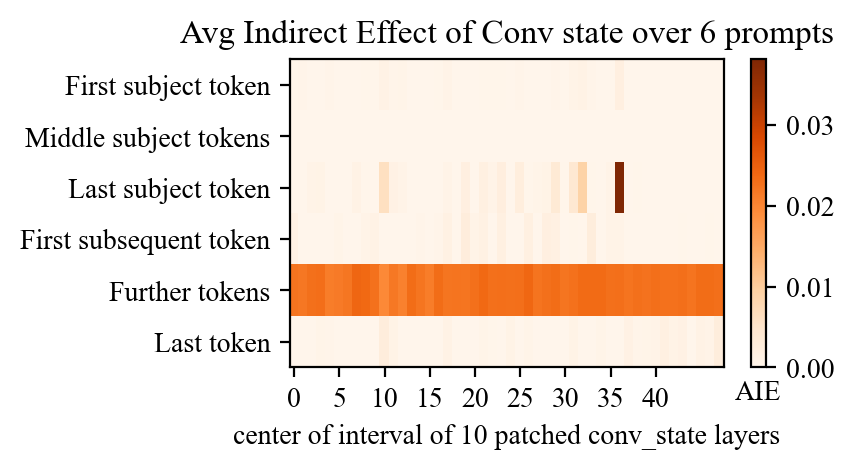

In [ ]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "ns3_r0_state-spaces_mamba-1.4b"
archname = "Mamba 1.4B"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'


class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    dirname = f"results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    cmap_dict = {
        None: "Purples",
        "None": "Purples",
        "": "Purples",
        "mlp": "Greens",
        "attn": "Reds",
        "ssm_state": "Blues",
        "conv_state": "Oranges",
    }
    h = ax.pcolor(
        differences,
        cmap=cmap_dict[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()


the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "ssm_state", "conv_state"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "ssm_state": "Indirect Effect of SSM state",
        "conv_state": "Indirect Effect of Conv state",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

In [8]:
dirname = f"results/{arch}/causal_trace/cases/"
kindcode = "" if not kind else f"_{kind}"
(
    avg_fe,
    avg_ee,
    avg_le,
    avg_fa,
    avg_ea,
    avg_la,
    avg_hs,
    avg_ls,
    avg_fs,
    avg_fle,
    avg_fla,
) = [Avg() for _ in range(11)]
for i in range(150):
    print(f"{dirname}/knowledge_{i}{kindcode}.npz")


results/gpt2-xl/causal_trace/cases//knowledge_0.npz
results/gpt2-xl/causal_trace/cases//knowledge_1.npz
results/gpt2-xl/causal_trace/cases//knowledge_2.npz
results/gpt2-xl/causal_trace/cases//knowledge_3.npz
results/gpt2-xl/causal_trace/cases//knowledge_4.npz
results/gpt2-xl/causal_trace/cases//knowledge_5.npz
results/gpt2-xl/causal_trace/cases//knowledge_6.npz
results/gpt2-xl/causal_trace/cases//knowledge_7.npz
results/gpt2-xl/causal_trace/cases//knowledge_8.npz
results/gpt2-xl/causal_trace/cases//knowledge_9.npz
results/gpt2-xl/causal_trace/cases//knowledge_10.npz
results/gpt2-xl/causal_trace/cases//knowledge_11.npz
results/gpt2-xl/causal_trace/cases//knowledge_12.npz
results/gpt2-xl/causal_trace/cases//knowledge_13.npz
results/gpt2-xl/causal_trace/cases//knowledge_14.npz
results/gpt2-xl/causal_trace/cases//knowledge_15.npz
results/gpt2-xl/causal_trace/cases//knowledge_16.npz
results/gpt2-xl/causal_trace/cases//knowledge_17.npz
results/gpt2-xl/causal_trace/cases//knowledge_18.npz
res

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

In [ ]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()